In [ ]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Mounted at /content/drive


## Pre-processing Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [ ]:
df['acc_ratio'] = df['acc_now_delinq'] / df['open_acc']
# df = df.drop(columns=['delinq_amnt', 'out_prncp', 'out_prncp_inv', 'acc_now_delinq', 'funded_amnt_inv'])
df = df.drop(columns=['acc_now_delinq', 'funded_amnt_inv'])
df_proc = df.copy()

In [ ]:
def cut_outlier(df2, columns):
    df=df2.copy()
    for column in columns:
        q1=df[column].quantile(.25)
        q3=df[column].quantile(.75)
        iqr=q3-q1
        low=q1-1.5*iqr
        high=q3+1.5*iqr
        df.loc[df[column]<low, column]=low
        df.loc[df[column]>high, column]=high
    return df

In [ ]:
df_proc_2 = cut_outlier(df_proc, list(df_proc.columns))
df_proc_2

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,total_rec_late_fee,term1,open_acc,installment,revol_util,total_rec_int,fico_range_low,fico_range_high,depvar,acc_ratio
0,0.0824,21000.0,29.19,0.0,1.0,0.0,3016.0,26.0,0.0,0.0,11773.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1200.0,0.0,1.0,18.0,37.74000,0.076,157.94000,757.5,761.5,0.0,0.0
1,0.1299,80000.0,4.82,0.0,1.0,0.0,5722.0,24.0,0.0,0.0,21875.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8000.0,0.0,1.0,8.0,269.52000,0.447,1702.42000,665.0,669.0,0.0,0.0
2,0.1299,38000.0,23.66,0.0,2.5,0.0,6511.0,18.0,0.0,0.0,31868.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000.0,0.0,1.0,7.0,168.45000,0.880,1066.64000,670.0,674.0,0.0,0.0
3,0.1367,100000.0,16.27,0.0,2.0,0.0,6849.0,30.0,0.0,0.0,326049.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15000.0,0.0,1.0,12.0,510.27000,0.457,1256.24000,680.0,684.0,1.0,0.0
4,0.1269,30000.0,25.28,0.0,1.0,0.0,8197.0,12.0,0.0,0.0,8840.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,0.0,1.0,8.0,335.45000,0.416,871.04000,660.0,664.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.1757,65000.0,17.67,0.0,2.5,0.0,11255.0,21.0,0.0,0.0,26570.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20000.0,0.0,1.0,13.0,718.75000,0.780,5373.29000,660.0,664.0,1.0,0.0
99996,0.0890,65000.0,2.88,0.0,0.0,0.0,2105.0,12.0,0.0,0.0,6138.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6000.0,0.0,1.0,7.0,190.52000,0.120,835.66000,757.5,761.5,0.0,0.0
99997,0.1349,46000.0,32.12,0.0,1.0,0.0,8998.0,20.0,0.0,0.0,96531.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6400.0,0.0,1.0,19.0,217.16000,0.643,1261.67000,665.0,669.0,0.0,0.0
99998,0.2115,31000.

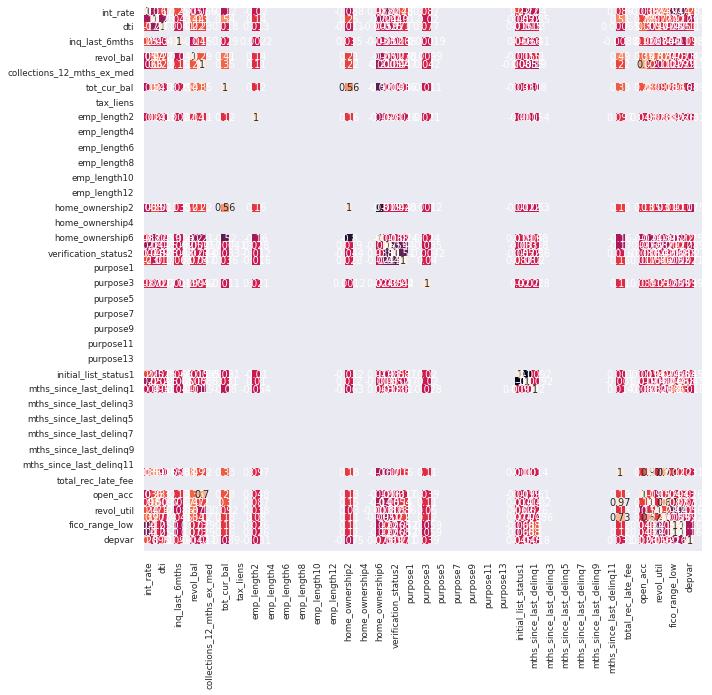

In [ ]:
data_corr=df_proc_2.corr()
#히트맵
plt.figure(figsize=(10,10))
sns.set(font_scale=0.8)
sns.heatmap(data_corr, annot=True, cbar=False)
plt.show()

## 전처리 작업 라벨링화

In [ ]:
auxtotal_rec_int = pd.cut(df_proc['total_rec_int'], 6) 
auxint_rate = pd.cut(df_proc['int_rate'], 15)      # 뒤쪽일수록 1비율 큼. 의미O
auxinstallment = pd.cut(df_proc['installment'], 15)  #특징 X
auxtot_cur_bal = pd.cut(df_proc['tot_cur_bal'], 10)  #뒤쪽으로 갈수록 1비율 낮음
auxdti = pd.cut(df_proc['dti'], 10)                # 뒤쪽으로 갈수록 0비율 높음 의미O
auxannual_inc = pd.cut(df_proc['annual_inc'], 10)  # 처음 1구간에 몰려있음
auxrevol_bal = pd.cut(df_proc['revol_bal'], 10)    # 처음 2구간에 몰려있음
auxrevol_util = pd.cut(df_proc['revol_util'], 10)  # 처음 2구간에 몰려있음
auxtotal_acc = pd.cut(df_proc['total_acc'], 10)    #특징 X
auxopen_acc = pd.cut(df_proc['open_acc'], 10)      #특징 X
auxfico_range_low = pd.cut(df_proc['fico_range_low'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfico_range_high = pd.cut(df_proc['fico_range_high'], 10)  #앞쪽일수록 1비율 큼. 의미O
auxfunded_amnt = pd.cut(df_proc['funded_amnt'], 10)  #앞쪽일 수록 0이 살짝 큰것같은데 미미함.

# aux_list 13개
aux_dict = {'total_rec_int':auxtotal_rec_int, 'int_rate':auxint_rate, 'installment':auxinstallment, 
            'tot_cur_bal':auxtot_cur_bal, 'dti':auxdti, 'annual_inc':auxannual_inc, 'revol_bal':auxrevol_bal, 'revol_util':auxrevol_util,
            'total_acc':auxtotal_acc, 'open_acc': auxopen_acc, 'fico_range_low':auxfico_range_low,
            'fico_range_high':auxfico_range_high, 'funded_amnt':auxfunded_amnt}

In [ ]:
# df_proc_2 부터는 구간 라벨링 시작
df_proc_2 = df_proc.copy()

In [ ]:
col_for_label = ['total_rec_int', 'int_rate',  'installment', 'tot_cur_bal',
                 'dti', 'annual_inc', 'revol_bal', 'revol_util', 'total_acc', 'open_acc', 'fico_range_low', 'fico_range_high', 'funded_amnt']

# name이 string타입이라 그냥 넣어주면 됨
for name in col_for_label:
    df_proc_2[name] = LabelEncoder().fit_transform(aux_dict[name])

In [ ]:
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

## 평가시작

In [ ]:
# 원본 train data 로 진행 // feature 모두 포함

X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

rnd_clf = RandomForestClassifier(max_depth=12, min_samples_leaf=8, min_samples_split=8, n_estimators=400, class_weight={0:1, 1:2}, random_state=42)
lgbm_clf = LGBMClassifier(max_depth=11, n_estimators=400, scale_pos_weight=2, random_state=42)
xgb_clf = xgboost.XGBClassifier(max_depth=7, n_estimators=400, eval_metric='logloss', scale_pos_weight=2, random_state=42) # 최적값 구한것

stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rnd',
                                RandomForestClassifier(class_weight={0: 1,
                                                                     1: 2},
                                                       max_depth=12,
                                                       min_samples_leaf=8,
                                                       min_samples_split=8,
                                                       n_estimators=400,
                                                       random_state=42)),
                               ('lgbm',
                                LGBMClassifier(max_depth=11, n_estimators=400,
                                               random_state=42,
                                               scale_pos_weight=2)),
                               ('xgb',
                                XGBClassifier(eval_metric='logloss',
                                              max_depth=7, n_estimators=400,
      

In [ ]:
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.7371
정밀도: 0.5798
재현율: 0.7368
AUC: 0.7371
F1: 0.6489


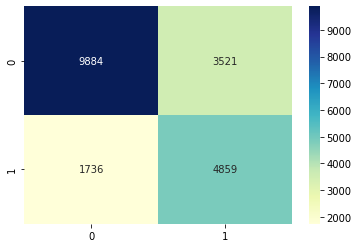

In [ ]:
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.3)   #0.6431
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.341)    #0.6444 -> 0.6489
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.4)   #0.6342

In [ ]:
# 제출 양식 다운로드
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')

# df_test 파일 수정
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
df_test['acc_ratio'] = df_test['acc_now_delinq'] / df_test['open_acc']
df_test = df_test.drop(columns=['acc_now_delinq', 'funded_amnt_inv'])

In [ ]:
# prediction 수행
submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.341
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_6.csv', index=False)

상한선 안걸어두고 진행했을 때 큰차이 안남, 고로 상한선 걸고 하겠음


정확도: 0.7182
정밀도: 0.5513
재현율: 0.7607
AUC: 0.7291
F1: 0.6393


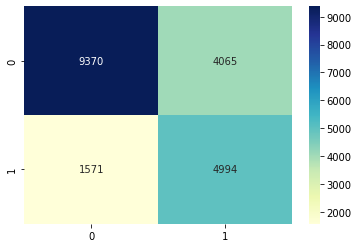

In [ ]:
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.316)  #0.6388 -> 상한선 안걸어두고 -> 0.6363

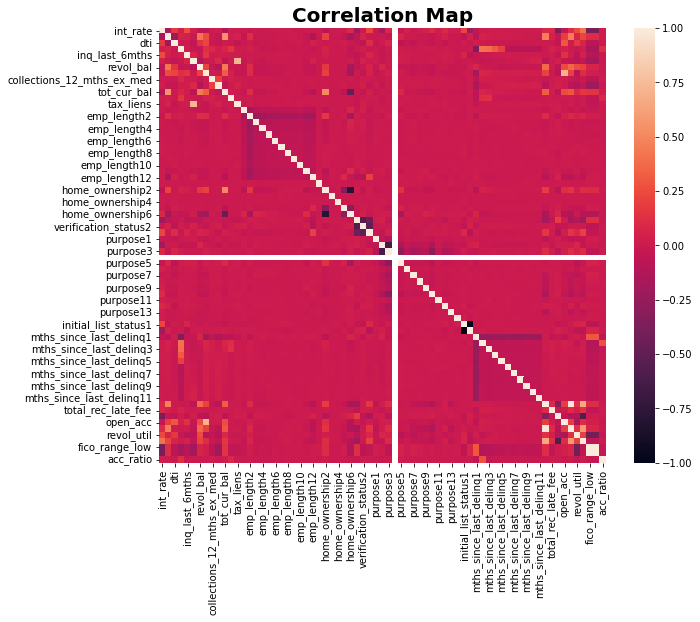

In [ ]:
corr_train = X_train.corr()
fig, axs = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_train).set_title("Correlation Map",fontdict= { 'fontsize': 20, 'fontweight':'bold'});
plt.show()